### `list_attr_celeba` Dataset
A popular component of computer vision and deep learning revolves around identifying faces for various applications from logging into your phone with your face or searching through surveillance images for a particular suspect. This dataset is great for training and testing models for face detection, particularly for recognising facial attributes such as finding people with brown hair, are smiling, or wearing glasses. Images cover large pose variations, background clutter, diverse people, supported by a large quantity of images and rich annotations. This data was originally collected by researchers at MMLAB, The Chinese University of Hong Kong (specific reference in Acknowledgment section).



- 202,599 number of face images of various celebrities
- 10,177 unique identities, but names of identities are not given
- 40 binary attribute annotations per image

You can obtain the dataset from https://www.kaggle.com/jessicali9530/celeba-dataset

In [1]:
import os
import PIL
import random
import math

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
import keras
from keras import optimizers
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, MaxPooling2D, BatchNormalization, Flatten
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [5]:
mypath = 'Downloads/celeb_small 2-20251231T162021Z-1-001'

In [6]:
filenames = os.listdir(os.path.join(mypath, 'celeb_small 2'))

In [7]:
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'man':
        categories.append(1)
    else:
        categories.append(0)

In [8]:
df = pd.DataFrame({'file_name':filenames,
                   'category':categories})

In [9]:
df.sample(10)

,file_name,category
1693,female.030364.jpg,0
3659,man.044196.jpg,1
659,female.011215.jpg,0
3464,man.038716.jpg,1
3114,man.029177.jpg,1
2735,man.020215.jpg,1
2774,man.021311.jpg,1
3081,man.028472.jpg,1
3645,man.043673.jpg,1
1017,female.017904.jpg,0


In [10]:
df['category'].value_counts()

category
0    1910
1    1892
Name: count, dtype: int64

<Axes: xlabel='category'>

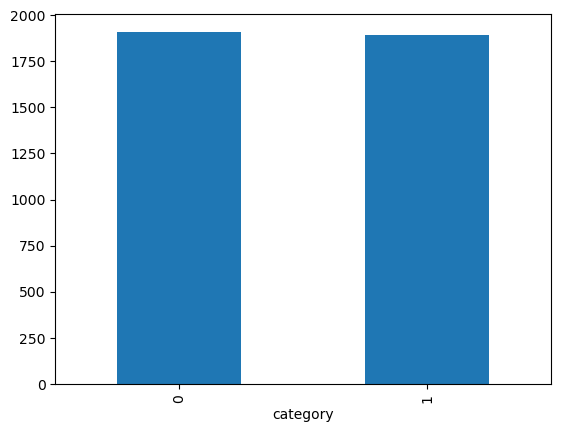

In [11]:
df['category'].value_counts().plot.bar()

#### See sample image

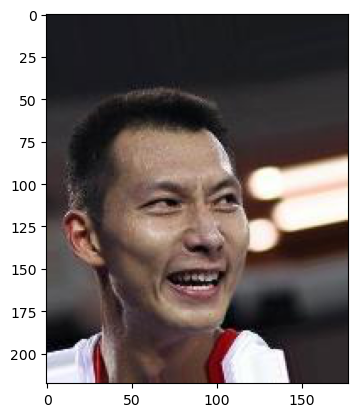

In [12]:
sample = random.choice(filenames)
image_path = os.path.join(mypath, 'celeb_small 2', sample)
sample_image = load_img(image_path)
plt.imshow(sample_image)

### 4. Build Model

- First, copy VGG16 without the dense layers, use the weights from `imagenet`. Set the input shape to `(178,218,3)`.
- Freeze the layers except the last two layers and print to see if the layers are trainable or not.
- Build your sequential model (you are free to use a functioanl API as a further exercise). Include all the frozen VGG layers to your model. Add a Dense layer with 128 inouts and `relu` activation. Add a batch nomalizer, then a dense layer as the output layer. 
- Create an early stopping criteria monitorin the loss value for the validation set. Stop the search if the loss value deosnt change for two consecutive times.
- Compile the model.
- Save the best model automatically based on the performance of the validation set.

In [13]:
vgg_model = VGG16(include_top = False, weights = 'imagenet', input_shape = (178, 218, 3))

In [14]:
vgg_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 178, 218, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 178, 218, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 178, 218, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 89, 109, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 89, 109, 128)        │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 89, 109, 128)        │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 44, 54, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 44, 54, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 44, 54, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 44, 54, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 22, 27, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 22, 27, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 22, 27, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 22, 27, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 11, 13, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 11, 13, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 11, 13, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 11, 13, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 5, 6, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
vgg_model.trainable = True

In [16]:
for layer in vgg_model.layers[:-2]:
    layer.trainable = False

In [17]:
for layer in vgg_model.layers:
    print(layer, layer.trainable)

<InputLayer name=input_layer, built=True> False
<Conv2D name=block1_conv1, built=True> False
<Conv2D name=block1_conv2, built=True> False
<MaxPooling2D name=block1_pool, built=True> False
<Conv2D name=block2_conv1, built=True> False
<Conv2D name=block2_conv2, built=True> False
<MaxPooling2D name=block2_pool, built=True> False
<Conv2D name=block3_conv1, built=True> False
<Conv2D name=block3_conv2, built=True> False
<Conv2D name=block3_conv3, built=True> False
<MaxPooling2D name=block3_pool, built=True> False
<Conv2D name=block4_conv1, built=True> False
<Conv2D name=block4_conv2, built=True> False
<Conv2D name=block4_conv3, built=True> False
<MaxPooling2D name=block4_pool, built=True> False
<Conv2D name=block5_conv1, built=True> False
<Conv2D name=block5_conv2, built=True> False
<Conv2D name=block5_conv3, built=True> True
<MaxPooling2D name=block5_pool, built=True> True


In [18]:
model1 = Sequential()

In [19]:
for layer in vgg_model.layers:
    model1.add(layer)

In [20]:
model1.add(Flatten())
model1.add(Dense(128, activation = 'relu'))
model1.add(BatchNormalization())
model1.add(Dense(2, activation = 'softmax'))

In [21]:
early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 2,
                           verbose = 1,
                           restore_best_weights = True)

In [22]:
checkpoint = ModelCheckpoint(filepath = 'gender_id_best_model.keras',
                             monitor = 'val_loss',
                             verbose = 1,
                             save_best_only = True,
                             mode = 'min')

In [23]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)                │ (None, 178, 218, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 178, 218, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 89, 109, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 89, 109, 128)        │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 89, 109, 128)        │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 44, 54, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 44, 54, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 44, 54, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 44, 54, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 22, 27, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 22, 27, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 22, 27, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 22, 27, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 11, 13, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 11, 13, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 11, 13, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 11, 13, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 5, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 15360)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,966,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 16,681,666 (63.64 MB)

 Trainable params: 4,326,530 (16.50 MB)

 Non-trainable params: 12,355,136 (47.13 MB)

In [24]:
for layer in model1.layers:
    print(layer, layer.trainable)

<Conv2D name=block1_conv1, built=True> False
<Conv2D name=block1_conv2, built=True> False
<MaxPooling2D name=block1_pool, built=True> False
<Conv2D name=block2_conv1, built=True> False
<Conv2D name=block2_conv2, built=True> False
<MaxPooling2D name=block2_pool, built=True> False
<Conv2D name=block3_conv1, built=True> False
<Conv2D name=block3_conv2, built=True> False
<Conv2D name=block3_conv3, built=True> False
<MaxPooling2D name=block3_pool, built=True> False
<Conv2D name=block4_conv1, built=True> False
<Conv2D name=block4_conv2, built=True> False
<Conv2D name=block4_conv3, built=True> False
<MaxPooling2D name=block4_pool, built=True> False
<Conv2D name=block5_conv1, built=True> False
<Conv2D name=block5_conv2, built=True> False
<Conv2D name=block5_conv3, built=True> True
<MaxPooling2D name=block5_pool, built=True> True
<Flatten name=flatten, built=True> True
<Dense name=dense, built=True> True
<BatchNormalization name=batch_normalization, built=True> True
<Dense name=dense_1, built=T

In [25]:
model1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

## 5. Data Preparation

- Create a validation set with 20% of the data. Check the number of data points per class from both the train and validation sets.
- Set your batch size to 20.
- Create the data generator and set the `preprocessing_function` to `preprocess_input` of VGG16.
- Create train and validation data generators (batches will be picked up from the dataframe). Set target size to (178,218) (you can try something else, but you need to do the corresponding change in the model).
- Set your validation  and epoch step size (`validation_steps` and `steps_per_epoch`)

In [26]:
df['category'] = df['category'].replace({0: 'female', 1: 'man'})

In [27]:
train_df, validate_df = train_test_split(df, 
                                         test_size = 0.2, 
                                         stratify = df['category'], 
                                         random_state = 42)

In [28]:
print(len(train_df), len(validate_df))

3041 761


In [29]:
train_df

,file_name,category
162,female.002467.jpg,female
52,female.000760.jpg,female
3366,man.036198.jpg,man
3235,man.032805.jpg,man
3599,man.042412.jpg,man
...,...,...
752,female.013331.jpg,female
1833,female.033290.jpg,female
2242,man.008417.jpg,man
3705,man.045251.jpg,man


In [30]:
validate_df

,file_name,category
1570,female.027733.jpg,female
3259,man.033360.jpg,man
960,female.016901.jpg,female
763,female.013578.jpg,female
1500,female.026542.jpg,female
...,...,...
3532,man.040685.jpg,man
385,female.006225.jpg,female
3294,man.034244.jpg,man
2723,man.019960.jpg,man


In [31]:
train_df = train_df.reset_index(drop = True)
validate_df = validate_df.reset_index(drop = True)

In [32]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                            rotation_range = 20,
                            width_shift_range = 0.1,
                            height_shift_range = 0.1,
                            horizontal_flip = True,
                            vertical_flip = True)

In [33]:
train_datagen = datagen.flow_from_dataframe(train_df,
                                            directory = os.path.join(mypath, 'celeb_small 2'),
                                            x_col = 'file_name',
                                            y_col = 'category',
                                            target_size = (178, 218),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            shuffle = True)

Found 3040 validated image filenames belonging to 2 classes.


C:\Users\sasan\anaconda3\Lib\site-packages\keras\src\legacy\preprocessing\image.py:918: UserWarning: Found 1 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  warnings.warn(


In [34]:
validate_datagen = datagen.flow_from_dataframe(validate_df,
                                            directory = os.path.join(mypath, 'celeb_small 2'),
                                            x_col = 'file_name',
                                            y_col = 'category',
                                            target_size = (178, 218),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            shuffle = False)

Found 761 validated image filenames belonging to 2 classes.


In [35]:
train_datagen.batch_size, validate_datagen.batch_size

(32, 32)

In [36]:
steps_per_epoch = len(train_df) // train_datagen.batch_size
steps_per_epoch

95

In [37]:
validation_steps = len(validate_df) // validate_datagen.batch_size
validation_steps

23

## 6. Train the Model

- Fit the model
- save the model

In [38]:
history = model1.fit(train_datagen,
           steps_per_epoch = steps_per_epoch,
           validation_data = validate_datagen,
           validation_steps = validation_steps,
           epochs = 3,
           callbacks = [early_stop, checkpoint])

Epoch 1/3
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8308 - loss: 0.4316  
Epoch 1: val_loss improved from None to 0.26188, saving model to gender_id_best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 467s 5s/step - accuracy: 0.8724 - loss: 0.3220 - val_accuracy: 0.8954 - val_loss: 0.2619
Epoch 2/3
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9150 - loss: 0.2216  
Epoch 2: val_loss improved from 0.26188 to 0.23609, saving model to gender_id_best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 449s 5s/step - accuracy: 0.9158 - loss: 0.2175 - val_accuracy: 0.9049 - val_loss: 0.2361
Epoch 3/3
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9146 - loss: 0.2031  
Epoch 3: val_loss improved from 0.23609 to 0.23052, saving model to gender_id_best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 431s 5s/step - accuracy: 0.9197 - loss: 0.1998 - val_accuracy: 0.9103 - val_loss: 0.2305
Restoring model weights from the end of the best epoch: 3.
